In [27]:
import pandas as pd
import numpy as np

In [28]:
raw = 'raw'
processed = 'processed'
features = 'features'
!mkdir -p processed features

In [29]:
from sklearn.preprocessing import OneHotEncoder

df_train = pd.read_csv(f'{raw}/train.csv')
df_test = pd.read_csv(f'{raw}/test.csv')

df_train['src'] = 'train'
df_test['src'] = 'test'
union = pd.concat([df_train, df_test], sort=False)

# 🧠 Derive features
## Sex: dummies

In [30]:
field_name = 'Sex'
dummies = pd.get_dummies(union['Sex'])
colnames = [f'{field_name}_{class_name}' for class_name in dummies.columns]
dummies.columns = colnames
union[colnames] = dummies[colnames]

## Fare: quantiles

In [31]:
union['Fare_is_na'] = union['Fare'].isnull().astype(int)
bin_col = pd.qcut(union['Fare'], 10)
bin_ind = pd.get_dummies(bin_col)
bin_ind.columns = [f'Fare_q_is({cat.left}..{cat.right}]' for cat in bin_ind.columns.values]
union[bin_ind.columns] = bin_ind

## Age: na, human ages dummies

In [32]:
union['Age_na'] = union['Age'].isnull().astype(int)

In [33]:
bin_col = pd.cut(union['Age'], bins=[0, 2, 6, 14, 16, 18, 25, 35, 40, 45, 60, 80])
bin_ind = pd.get_dummies(bin_col)
bin_ind.columns = [f'Age_is({cat.left}..{cat.right}]' for cat in bin_ind.columns.values]
union[bin_ind.columns] = bin_ind

## Age: quantiles

In [34]:
bin_col = pd.qcut(union['Age'], 10)
bin_ind = pd.get_dummies(bin_col)
bin_ind.columns = [f'Age_q_is({cat.left}..{cat.right}]' for cat in bin_ind.columns.values]
union[bin_ind.columns] = bin_ind

In [35]:
union = pd.get_dummies(union, columns=['Pclass'], prefix='Pclass_is')

## Name: title_ind, survival by title

In [36]:
def extract_title(full_name):
    first_plus_title = (full_name.split(","))[1]
    return (first_plus_title.split())[0]

union['Name_title'] = union['Name'].apply(extract_title)
union['Name_title'].value_counts()
survival_by_title = union.pivot_table(
    index='Name_title',
    aggfunc=['mean', 'count'],
    values='Survived')\
.stack().reset_index().sort_values('count', ascending=False)


# titles are either too infrequent to help with more predictions
# or don't seem to provide a lot of survival prediction direction vs e.g. Mr.
counts = union['Name_title'].value_counts().to_dict();
for title, count in counts.items():
    if count < 10:
        union.loc[union['Name_title'] == title,'Name_title'] = 'Other.'

/usr/local/lib/python3.7/site-packages/pandas/core/reshape/pivot.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return concat(pieces, keys=keys, axis=1)


In [37]:
survival_by_title = union.pivot_table(
    index='Name_title',
    aggfunc=['mean', 'count'],
    values='Survived')\
.stack().reset_index().sort_values('count', ascending=False)
survival_by_title

,Name_title,level_1,mean,count
2,Mr.,Survived,0.156673,517
1,Miss.,Survived,0.697802,182
3,Mrs.,Survived,0.792000,125
0,Master.,Survived,0.575000,40
4,Other.,Survived,0.444444,27


In [38]:
union['Name_title_survival_odds'] = union.query('src == "train"')\
     [['Name_title', 'Survived']]\
     .groupby('Name_title')\
     .transform(lambda series: series.mean())

In [39]:
union = pd.get_dummies(union, columns=['Name_title'], prefix='Name_title_is')

## Name: last_survival_odds

In [40]:
def extract_last_name(full_name):
    return (full_name.split(","))[0]

union['Name_last'] = union['Name'].apply(extract_last_name)
union['Name_last'].value_counts()[:3]

Andersson    11
Sage         11
Asplund       8
Name: Name_last, dtype: int64

In [41]:
union['Name_last_odds_survival'] = union.query('src == "train"')\
    [['Name_last', 'Survived']]\
    .groupby('Name_last')\
    .transform(lambda x: x.mean())\
    ['Survived']

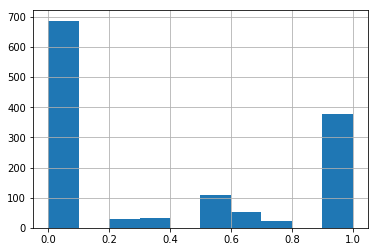

In [53]:
union['Name_last_odds_survival'].hist(bins=10)

In [42]:
union.columns

Index(['PassengerId', 'Survived', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'src', 'Sex_female', 'Sex_male',
       'Fare_is_na', 'Fare_q_is(-0.001..7.568]', 'Fare_q_is(7.568..7.854]',
       'Fare_q_is(7.854..8.05]', 'Fare_q_is(8.05..10.5]',
       'Fare_q_is(10.5..14.454]', 'Fare_q_is(14.454..21.679]',
       'Fare_q_is(21.679..26.955]', 'Fare_q_is(26.955..41.579]',
       'Fare_q_is(41.579..78.051]', 'Fare_q_is(78.051..512.329]', 'Age_na',
       'Age_is(0..2]', 'Age_is(2..6]', 'Age_is(6..14]', 'Age_is(14..16]',
       'Age_is(16..18]', 'Age_is(18..25]', 'Age_is(25..35]', 'Age_is(35..40]',
       'Age_is(40..45]', 'Age_is(45..60]', 'Age_is(60..80]',
       'Age_q_is(0.169..14.0]', 'Age_q_is(14.0..19.0]', 'Age_q_is(19.0..22.0]',
       'Age_q_is(22.0..25.0]', 'Age_q_is(25.0..28.0]', 'Age_q_is(28.0..31.0]',
       'Age_q_is(31.0..36.0]', 'Age_q_is(36.0..42.0]', 'Age_q_is(42.0..50.0]',
       'Age_q_is(50.0..80.0]', 'Pclass_is_1', 'Pclass_is_

In [43]:
df_train = union[union['src'] == 'train']
df_test  = union[union['src'] == 'test']

In [44]:
len(df_train), len(df_test), len(union)

(891, 418, 1309)

In [45]:
df_train.to_csv(f'{processed}/train.csv', index=False)
df_test.to_csv(f'{processed}/test.csv', index=False)

# 💾 Output
## Age: dummies(quantiles)

In [46]:
quantile_age_features = [col_name for col_name in df_train.columns if 'Age_q_is' in col_name]
df_train[['PassengerId'] + quantile_age_features].to_csv(f'{features}/age_quantiles_train.csv', index=False)
df_test[['PassengerId'] + quantile_age_features].to_csv(f'{features}/age_quantiles_test.csv', index=False)

## Age: dummies(human bins)

In [47]:
human_age_features = [col_name for col_name in df_train.columns if 'Age_is' in col_name]
df_train[['PassengerId'] + human_age_features].to_csv(f'{features}/age_human_train.csv', index=False)
df_test[['PassengerId'] + human_age_features].to_csv(f'{features}/age_human_test.csv', index=False)

## Fare: dummies(quantiles)

In [48]:
quantile_fare_features = [col_name for col_name in df_train.columns if 'Fare_q_is' in col_name]
df_train[['PassengerId'] + human_age_features].to_csv(f'{features}/fare_quantiles_train.csv', index=False)
df_test[['PassengerId'] + human_age_features].to_csv(f'{features}/fare_quantiles_test.csv', index=False)

## Pclass: dummies

In [49]:
pclass_features = [col_name for col_name in df_train.columns if 'Pclass_is_' in col_name]
df_train[['PassengerId'] + pclass_features].to_csv(f'{features}/pclass_dummy_train.csv', index=False)
df_test[['PassengerId'] + pclass_features].to_csv(f'{features}/pclass_dummy_test.csv', index=False)

## Name

In [50]:
name_features = [col_name for col_name in df_train.columns if 'Name_' in col_name]
df_train[['PassengerId'] + pclass_features].to_csv(f'{features}/name_features_train.csv', index=False)
df_test[['PassengerId'] + pclass_features].to_csv(f'{features}/name_features_test.csv', index=False)

In [51]:
df_train.columns

Index(['PassengerId', 'Survived', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'src', 'Sex_female', 'Sex_male',
       'Fare_is_na', 'Fare_q_is(-0.001..7.568]', 'Fare_q_is(7.568..7.854]',
       'Fare_q_is(7.854..8.05]', 'Fare_q_is(8.05..10.5]',
       'Fare_q_is(10.5..14.454]', 'Fare_q_is(14.454..21.679]',
       'Fare_q_is(21.679..26.955]', 'Fare_q_is(26.955..41.579]',
       'Fare_q_is(41.579..78.051]', 'Fare_q_is(78.051..512.329]', 'Age_na',
       'Age_is(0..2]', 'Age_is(2..6]', 'Age_is(6..14]', 'Age_is(14..16]',
       'Age_is(16..18]', 'Age_is(18..25]', 'Age_is(25..35]', 'Age_is(35..40]',
       'Age_is(40..45]', 'Age_is(45..60]', 'Age_is(60..80]',
       'Age_q_is(0.169..14.0]', 'Age_q_is(14.0..19.0]', 'Age_q_is(19.0..22.0]',
       'Age_q_is(22.0..25.0]', 'Age_q_is(25.0..28.0]', 'Age_q_is(28.0..31.0]',
       'Age_q_is(31.0..36.0]', 'Age_q_is(36.0..42.0]', 'Age_q_is(42.0..50.0]',
       'Age_q_is(50.0..80.0]', 'Pclass_is_1', 'Pclass_is_